# Birth Defects for Nebraska - EPHTracking Fall 2023 Data Call
- Babak J.Fard -- October 2023

This notebook shows the steps in creating the Birth Defects (BD) datasets-as required by the Tracking How-To-Guide (HTG) and Data Dictionary- from the raw datasets. Since the format of the raw dataset maybe very specific and different from other states (even from the future BD datasets) no separate python code (.py file) is created. The user is suggested to consider the potential differences and changes for use with other datasets. The notebook is reorganized into four sections to be easy to follow.

* All cell outputs that may contain detailed level health data are removed.

In [1]:
# Import the libraries for data validation
import numpy as np
import pandas as pd

#from libraries import Validator_Nebraska_2023_BirthDefects as VNBD
from libraries import general as ge
#from pydantic import ValidationError

#from itables import init_notebook_mode

#init_notebook_mode(all_interactive=True)


import os
os.chdir('/Users/babak.jfard/projects/EPHTracking')

## 1. Preparing the Birth Defects Data
Using the provided dataset, we have created a validator class. In this step we validate the raw data using Neraska Birth Defect validator. 

In [2]:
bd_2 = pd.read_csv('Data/BIRTHDEFECTS080823/bd10_9/bd10_9.csv', na_values=['nan'], dtype=str)

In [ ]:
# According to the HTG-Appendix A, for BD 27 of CDC/BPA is must exclude 752.61
# Since we have CDC/BPA codes before 2015 we replace all these values with ''
# to make sure those are excluded
bd_2[bd_2['d15'].fillna('').str.startswith('752.621')]

In [5]:
# For when considering CDC/BPA is used instead of ICD-9, we replace all these values with ''
bd_2.loc[bd_2['d15']=='752.621', 'd15'] = ''

In [6]:
# double check
bd_2[bd_2['d15'].fillna('').str.startswith('752.621')]

Empty DataFrame
Columns: [d16, d15, sex, dob_c, bthyr, dob_m, stresm, cou, case_id, bth_cert1, fetal_cert, dth_cert, racethm]
Index: []

In [7]:
# Checking if the maternal state of residence is NE
bd_2.stresm.value_counts(dropna=False)

stresm
Nebraska    74724
NaN            91
nebraska        2
Unknown         1
Utah            1
Name: count, dtype: int64

In [8]:
# Only keeping those that maternal state in Nebraska
bd_2 = bd_2[bd_2['stresm'].str.lower() == 'nebraska']

In [9]:
# Remove the extra column
bd_2 = bd_2.drop(columns='stresm')

In [10]:
# Those that birth certificate and fetal death do not match. If fetal_cert is not na, no birth certificate number must be null
bd_2[bd_2['fetal_cert'].notna()]['bth_cert1'].value_counts(dropna=False)

bth_cert1
NaN           531
2021001326      4
2022003593      1
Name: count, dtype: int64

In [12]:
# Removing those that the fetal death condition is not null, and  birth certificate is not null too
bd_2 = bd_2[~(bd_2['fetal_cert'].notna() & bd_2['bth_cert1'].notna())]


Looks like we have a big change between the two datasets. The old one and the new one just provided!

###  Dates
reminder from HTG:
* A row of data is a unique combination of County, Startdate, Enddate, BirthDefect, MaternalAgeGroup, MaternalRace, and MaternalEthnicity, Infantsex

In [13]:
# Change date columns into datetime format
bd_2['dob_c'] = pd.to_datetime(bd_2['dob_c'], format='%m/%d/%Y', errors='coerce')
bd_2['dob_m'] = pd.to_datetime(bd_2['dob_m'], format='%m/%d/%Y', errors='coerce')

In [14]:
bd_2 = bd_2[bd_2['dob_c'].dt.year <= 2021]

### Maternal Age
This section is about the mother's ages and the corrections

In [15]:
# Some of the date of births for mothers are weird. Will change them into NA
# bd_2.loc[bd_2['dob_m'].dt.year < 1930].replace('dob_m', pd.NA, inplace=True)
bd_2.loc[bd_2['dob_m'].dt.year < 1930, 'dob_m'] = pd.NA


In [16]:
# Double check if the extracted years from 'dob_c' actually matches those in bthyr column
sum(bd_2.dob_c.dt.year.astype('int') - bd_2.bthyr.astype('int'))

0

In [17]:
bd_2['Mom_Age'] = bd_2['bthyr'].astype('int') - bd_2['dob_m'].dt.year

In [18]:
bd_2[bd_2['Mom_Age'] <= 12]

d16      d15 sex      dob_c bthyr      dob_m      cou case_id  \
16478    NaN  756.340   M 2007-05-12  2007 2019-06-17  Douglas   47648   
59905  Q82.6      NaN   M 2019-10-18  2019 2019-10-18  Douglas   89549   
59906  Q21.0      NaN   M 2019-10-18  2019 2019-10-18  Douglas   89549   
72266  Q82.6      NaN   F 2021-02-23  2021 2021-10-24  Douglas   98062   

        bth_cert1 fetal_cert dth_cert racethm  Mom_Age  
16478  2007019092        NaN      NaN       9    -12.0  
59905  2019020147        NaN      NaN       1      0.0  
59906  2019020147        NaN      NaN       1      0.0  
72266  2021002988        NaN      NaN       1      0.0

In [19]:
# correcting for these ages
bd_2.loc[bd_2['Mom_Age'] <= 12, 'dob_m'] = pd.NA

# recalcualting Mom_Age
bd_2['Mom_Age'] = bd_2['bthyr'].astype('int') - bd_2['dob_m'].dt.year

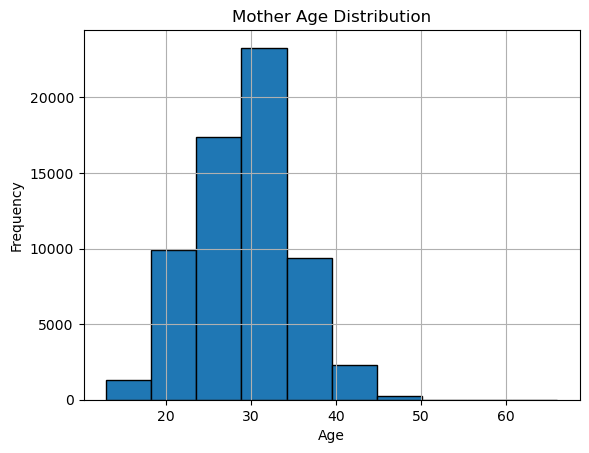

In [20]:
import matplotlib.pyplot as plt

# Plotting the histogram
bd_2['Mom_Age'].hist(bins=10, edgecolor='black')
plt.title('Mother Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Categorizing ages into MaternalAgeGroup
# Categorizing maternal age into the groups from Birth Defects Dictionary, May 2022
def categorize_age(df, age_col = 'Mom_Age', new_col= 'MaternalAgeGroup'):
    # Define the age categorization function
    def age_category(age):
        if age < 20:
            return 1
        elif 20 <= age <= 24:
            return 2
        elif 25 <= age <= 29:
            return 3
        elif 30 <= age <= 34:
            return 4
        elif 35 <= age <= 39:
            return 5
        elif age >= 40:
            return 6
        else:
            return 9  # Unknown

    # Apply the age categorization function to the 'Mom_Age' column
    df[new_col] = df[age_col].apply(age_category)
    return df


In [22]:
bd_2 = categorize_age(bd_2)
# matches = categorize_age(matches)


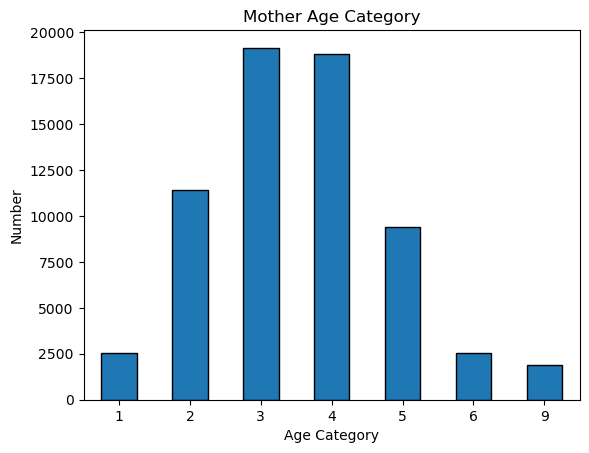

In [23]:
# Count the occurrences of each category
age_counts = bd_2['MaternalAgeGroup'].value_counts()

# Sort the index
age_counts = age_counts.sort_index()

# Plotting the bar plot
age_counts.plot(kind='bar', edgecolor='black', align='center')
plt.title('Mother Age Category')
plt.xlabel('Age Category')
plt.ylabel('Number')
plt.xticks(rotation=0)  # Ensure x-axis labels are horizontal
plt.show()

### County Codes
The provided counties are in names format. In this section created a column for their corresponding FIPS codes

In [24]:
# Getting the numeric FIPS code
fips = ge.get_Counties_FIPS()
fips['county_name'] = fips['county_name'].str.lower()
fips['county_name'] = fips['county_name'].str.replace(" county", "")


bd_2['cou'] = bd_2['cou'].str.lower()

In [25]:
bd_2 = bd_2.merge(fips, left_on='cou', right_on='county_name')

In [26]:
# Check if the merge has worked out fine!
bd_2[bd_2['cou'] != bd_2['county_name']]

Empty DataFrame
Columns: [d16, d15, sex, dob_c, bthyr, dob_m, cou, case_id, bth_cert1, fetal_cert, dth_cert, racethm, Mom_Age, MaternalAgeGroup, fips, county_name]
Index: []

In [27]:
# Removing cou and renaming the new column
bd_2 = bd_2.drop(columns=['cou', 'county_name'])
bd_2.rename(columns={'fips': 'County', 'sex':'InfantSex'}, inplace=True)

### Maternal Race and Ethnicity
Following HTG one column for each

In [28]:
race = {1:'W', 2:'B', 3:'O', 4:'O', 8:'O', 9:'U'}
ethnicity = {1:'NH', 2:'NH', 3:'NH', 4:'NH', 8: 'H', 9:'U'}

In [30]:
bd_2.racethm = bd_2.racethm.astype('int')

In [31]:
bd_2['MaternalEthnicity'] = bd_2['racethm'].replace(ethnicity)
bd_2['MaternalRace'] = bd_2['racethm'].replace(race)

In [32]:
bd_2 = bd_2.drop(columns='racethm')

In [33]:
bd_2['StartDate'] = bd_2['bthyr'].astype('str')+'0101'
bd_2['EndDate'] = bd_2['bthyr'].astype('str')+'1231'

In [35]:
bd_2 = bd_2.drop(columns=['dob_c', 'bthyr', 'dob_m', 'case_id', 'Mom_Age'])

### Converting ICD-9 and ICD-10s to BirthDefect Codes

In [36]:
import json

# Reading ICD-9 codes related to the Birth Defects
with open('Data/Dictionaries/BirthDefects_icd_9_convert.json', 'r') as f:
     icd_9_dict = json.load(f)

# Reading CDC/BPA codes related to the Birth Defects
with open('Data/Dictionaries/BirthDefects_CDC_BPA_convert.json', 'r') as f:
    icd_BPA_dict = json.load(f)

In [37]:
with open('Data/Dictionaries/BirthDefects_icd_10_convert.json') as f:
    icd_10_dict = json.load(f)

In [153]:
icd_BPA_dict

{'740.00': 21,
 '740.01': 21,
 '740.02': 21,
 '740.03': 21,
 '740.04': 21,
 '740.05': 21,
 '740.06': 21,
 '740.07': 21,
 '740.08': 21,
 '740.09': 21,
 '740.10': 21,
 '749.20': 22,
 '749.21': 22,
 '749.22': 22,
 '749.23': 22,
 '749.24': 22,
 '749.25': 22,
 '749.26': 22,
 '749.27': 22,
 '749.28': 22,
 '749.29': 22,
 '749.10': 23,
 '749.11': 23,
 '749.12': 23,
 '749.13': 23,
 '749.14': 23,
 '749.15': 23,
 '749.16': 23,
 '749.17': 23,
 '749.18': 23,
 '749.19': 23,
 '749.00': 24,
 '749.01': 24,
 '749.02': 24,
 '749.03': 24,
 '749.04': 24,
 '749.05': 24,
 '749.06': 24,
 '749.07': 24,
 '749.08': 24,
 '749.09': 24,
 '756.71': 25,
 '746.70': 26,
 '752.60': 27,
 '752.62': 27,
 '755.20': 28,
 '755.21': 28,
 '755.22': 28,
 '755.23': 28,
 '755.24': 28,
 '755.25': 28,
 '755.26': 28,
 '755.27': 28,
 '755.28': 28,
 '755.29': 28,
 '755.30': 28,
 '755.31': 28,
 '755.32': 28,
 '755.33': 28,
 '755.34': 28,
 '755.35': 28,
 '755.36': 28,
 '755.37': 28,
 '755.38': 28,
 '755.39': 28,
 '755.40': 28,
 '755.41':

In [154]:
# this function maps the values of icd_9 or icd_10 into the values of BirthDefect 12 codes
# This method was not used
# def lookup_icd_value(value, icd_code = 10):
#     if icd_code == 10:
#         return icd_10_dict.get(value, np.nan)
#     if icd_code == 9:
#         return icd_9_dict.get(value, np.nan)
#     
# # Creating a column mapping from ICD-9
# bd['BIRTH_DEFECTS_from_9'] = bd['DEFECT_CODE'].apply(lookup_icd_value, icd_code = 9)
# bd['BIRTH_DEFECTS_from_10'] = bd['DEFECT_CODE10CM'].apply(lookup_icd_value)

In [39]:
# The second method: Instead of the exact match, look if it starts with a key in the dictionary
def lookup_icd_value_startsWith(value, icd_code=10):
    if pd.isnull(value):
        return np.nan
    # value = str(value)
    if icd_code == 10:
        for key in icd_10_dict:
            if value.startswith(key):
                return icd_10_dict[key]
        return np.nan
    if icd_code == 9:
        for key in icd_9_dict:
            if value.startswith(key):
                return icd_9_dict[key]
        return np.nan
    if icd_code == 8:
        for key in icd_BPA_dict:
            if value.startswith(key):
                return icd_BPA_dict[key]
    
# Creating a column mapping from ICD-9
#bd_2['BIRTH_DEFECTS_from_9'] = bd_2['d15'].apply(lookup_icd_value_startsWith, icd_code = 9)
bd_2['BIRTH_DEFECTS_from_9'] = bd_2['d15'].apply(lookup_icd_value_startsWith, icd_code = 8)
bd_2['BIRTH_DEFECTS_from_10'] = bd_2['d16'].apply(lookup_icd_value_startsWith)

In [40]:
# Birth Defects out of our 12 categories
not_matches = bd_2[bd_2['BIRTH_DEFECTS_from_9'].isna() & bd_2['BIRTH_DEFECTS_from_10'].isna()]

# Birth Defects of our 12 categories
matches = bd_2[bd_2['BIRTH_DEFECTS_from_9'].notna() | bd_2['BIRTH_DEFECTS_from_10'].notna()]


Checking what percentages of total birth defects for 2005 to 2021 are from the 12 categories from the Tracking(below shows it's around 6.3%)

In [41]:
matches.shape[0]* 100 / bd_2.shape[0]

8.289161030890147

In [42]:
# Checking if the duplicated values that values for both ICD-10 and CDC/BPA result into similar BD ids
dup_check = bd_2[bd_2['BIRTH_DEFECTS_from_10'].notna() & bd_2['BIRTH_DEFECTS_from_9'].notna()]
sum(dup_check['BIRTH_DEFECTS_from_10'] != dup_check['BIRTH_DEFECTS_from_9'])

0

In [43]:
# Merge the two columns into BirthDefect column
def merge_defect_columns(row, ICD_9_Col='BIRTH_DEFECTS_from_9', ICD_10_Col= 'BIRTH_DEFECTS_from_10'):
    val_10 = row[ICD_10_Col]
    val_9 = row[ICD_9_Col]
    
    if pd.isna(val_10) and pd.isna(val_9):
        return np.nan
    elif pd.isna(val_10):
        return val_9
    elif pd.isna(val_9):
        return val_10
    else:
        return val_10 if val_10 == val_9 else np.nan

bd_2['BirthDefects'] = bd_2.apply(merge_defect_columns, axis=1)

In [44]:
bd_2['BirthDefects'].value_counts(dropna=False)

BirthDefects
NaN     60210
27.0     1943
32.0      844
22.0      397
29.0      378
24.0      374
28.0      352
23.0      257
31.0      248
25.0      234
30.0      159
26.0      148
21.0      108
Name: count, dtype: int64

### Final preparations of the Birth Defect data

* We are only interested in `matches` section of data that contains the 12 BDs of interest

In [45]:
matches['BirthDefect'] = matches.apply(merge_defect_columns, axis=1)
matches['BirthDefect'].value_counts(dropna=False)

/var/folders/tx/f40dd1zx7154kx9yjmytmw_00000gr/T/ipykernel_79146/1431824544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches['BirthDefect'] = matches.apply(merge_defect_columns, axis=1)


BirthDefect
27.0    1943
32.0     844
22.0     397
29.0     378
24.0     374
28.0     352
23.0     257
31.0     248
25.0     234
30.0     159
26.0     148
21.0     108
Name: count, dtype: int64

In [46]:
matches.MaternalEthnicity.value_counts(dropna=False)

MaternalEthnicity
NH    4500
H      756
U      186
Name: count, dtype: int64

In [47]:
matches.MaternalRace.value_counts(dropna=False)

MaternalRace
W    4042
O     927
B     287
U     186
Name: count, dtype: int64

In [48]:
# Percent of live births with the specified birth defects
matches.bth_cert1.notna().sum()*100/matches.shape[0]

97.85005512679162

In [49]:
# Percent of fetal death with the specified birth defects
matches.fetal_cert.notna().sum()*100/matches.shape[0]

2.1499448732083795

In [50]:
matches.columns

Index(['d16', 'd15', 'InfantSex', 'bth_cert1', 'fetal_cert', 'dth_cert',
       'MaternalAgeGroup', 'County', 'MaternalEthnicity', 'MaternalRace',
       'StartDate', 'EndDate', 'BIRTH_DEFECTS_from_9', 'BIRTH_DEFECTS_from_10',
       'BirthDefect'],
      dtype='object')

In [52]:
group_by = ['BirthDefect', 'County', 'StartDate', 'EndDate','MaternalAgeGroup', 'MaternalEthnicity', 'MaternalRace',
                   'InfantSex']

In [53]:
# bd_grouped = matches.groupby(group_by).agg(LBWBD=('bth_cert1', 'size')).reset_index()
bd_grouped = matches.groupby(group_by).agg(LBWBD=('bth_cert1', lambda x: x.notna().sum()),
                                           LBFDTWD=('bth_cert1', 'size')).reset_index()


In [54]:
bd_grouped.to_csv('Data/BIRTHDEFECTS080823/BirthDefects_without_TBL_BPA.csv')

In [ ]:
# At the end of this section the following command deletes all the memory.
%reset

## 2.Preparing the Live Birth Data

In [ ]:
import numpy as np
import pandas as pd


from libraries import general as ge

# from itables import init_notebook_mode

#init_notebook_mode(all_interactive=True)


import os
os.chdir('/Users/babak.jfard/projects/EPHTracking')

In [2]:
#live_births = pd.read_csv('Data/BIRTHDEFECTS080823/Live Births/bth2005.csv')
folder = r'Data/BIRTHDEFECTS080823/Live Births'
live_births = pd.concat((pd.read_csv(folder+'/'+filename)) for filename in os.listdir(folder) if filename.endswith('.csv'))

In [7]:
print("Number of live births in each year")
live_births.DOB_YY.value_counts()

Number of live births in each year


2009    25899
2008    25885
2007    25822
2014    25819
2015    25728
2006    25661
2016    25656
2013    25159
2005    25103
2012    25010
2010    24937
2017    24885
2011    24834
2018    24538
2019    23860
2021    23646
2020    23419
Name: DOB_YY, dtype: int64

In [4]:
# keep only those with mother state of residence as NE
live_births = live_births[live_births.strm == 'NE']

In [6]:
live_births['coures'].nunique()

93

### Correcting the FIPS code, Maternal Ethnicity, and Dates
received FIPS codes for the counties are in three digit format. needs to be chanded into five digits

In [8]:
# Making FIPS codes into 5 dgigts
state_FIPS = '31' #For Nebraska.

live_births.coures = live_births.coures.astype('str').str.zfill(3) #Pad strings in the Series/Index by prepending ‘0’ characters.
live_births['County'] = (state_FIPS+ live_births['coures']).astype('int')
live_births.drop(columns='coures', inplace=True)

In [9]:
live_births['StartDate'] = live_births['DOB_YY'].astype('str') + '0101'

In [10]:
live_births.rename(columns={'sex': 'InfantSex'}, inplace=True)

In [11]:
# Distinguishing Ethnicity
# Define the conditions and choices
conditions = [
    live_births['hispanicm'].str.contains('H'),
    live_births['hispanicm'].str.contains('U')
]
choices = ['H', 'U']

# Create the new column using np.select
live_births['MaternalEthnicity'] = np.select(conditions, choices, default='NH')
live_births = live_births.drop(columns='hispanicm')

In [12]:
live_births.MaternalEthnicity.value_counts()

NH    360100
H      65593
U        168
Name: MaternalEthnicity, dtype: int64

In [15]:
# Categorizing maternal age into the groups from the HTG, and saving it into the appropriate column
live_births = categorize_age(live_births, age_col='agemo')

### Editing Maternal Race

In [16]:
race_other_columns = ['aindianm', 'chamorrom', 'chinesem', 'filipinom', 'indianm', 'japanesem',
                      'koreanm', 'nhawaiianm', 'opacislm', 'otheram', 'otherm', 'samoanm', 'vietnamesem']
race_black_columns = 'blackm'
race_white_columns = 'whitem'

In [17]:
# checking the unique values in all other race columns are 'Y' or 'N'
[print(f"{col}: {live_births[col].value_counts(dropna=False)}") for col in race_other_columns]

aindianm: N    422923
Y      2938
Name: aindianm, dtype: int64
chamorrom: N    425594
Y       267
Name: chamorrom, dtype: int64
chinesem: N    424307
Y      1554
Name: chinesem, dtype: int64
filipinom: N    424199
Y      1662
Name: filipinom, dtype: int64
indianm: N    418615
Y      7246
Name: indianm, dtype: int64
japanesem: N    425135
Y       726
Name: japanesem, dtype: int64
koreanm: N    424915
Y       946
Name: koreanm, dtype: int64
nhawaiianm: N    425645
Y       216
Name: nhawaiianm, dtype: int64
opacislm: N    425521
Y       340
Name: opacislm, dtype: int64
otheram: N    422109
Y      3752
Name: otheram, dtype: int64
otherm: N    375978
Y     49883
Name: otherm, dtype: int64
samoanm: N    425768
Y        93
Name: samoanm, dtype: int64
vietnamesem: N    423590
Y      2271
Name: vietnamesem, dtype: int64


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [18]:
# changing to digist to better be able to check consistency
to_digits = {'Y':1, 'N':0}

In [19]:
[live_births[col].replace(to_digits, inplace=True) for col in race_other_columns]

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [20]:
# Calculating all into one column for other
live_births['race_other'] = live_births[race_other_columns].sum(axis=1)
live_births['race_other'] = np.where(live_births['race_other']>0, 1, 0)

In [21]:
# Doing the same for Black and White races
live_births[race_white_columns].replace(to_digits, inplace=True)
live_births[race_black_columns].replace(to_digits, inplace=True)

In [22]:
# checking potential values. In an ideal situation there must be only one
# or 0 for unknown
three_races = ['blackm', 'whitem', 'race_other']
live_births[three_races].sum(axis=1).value_counts(dropna=False)

1    412706
2     11786
0       720
3       649
dtype: int64

Well. Looks good. only about 3% are not 1. Now if this value is other than one it will return 'U', otherwise checks which of 'W', 'B' or 'O' applies

In [23]:
# Calculate the sum of the three columns
live_births['sum_race'] = live_births[['blackm', 'whitem', 'race_other']].sum(axis=1)

# Define the conditions and choices for the 'MaternalRace' column
conditions = [
    (live_births['sum_race'] != 1),
    (live_births['blackm'] == 1),
    (live_births['whitem'] == 1),
    (live_births['race_other'] == 1)
]
choices = ['U', 'B', 'W', 'O']

# Create the 'MaternalRace' column using numpy.select
live_births['MaternalRace'] = np.select(conditions, choices)

# Drop the 'sum_race' column as it's no longer needed
live_births.drop('sum_race', axis=1, inplace=True)


In [24]:
live_births.MaternalRace.value_counts()

W    324607
O     62008
B     26091
U     13155
Name: MaternalRace, dtype: int64

### Wrapping up
Here we prepare, rename and reorder column to get ready for joining with the birth defects data

In [25]:
columns_to_keep = ['County', 'StartDate', 'MaternalAgeGroup', 'MaternalEthnicity', 'MaternalRace',
                   'InfantSex']
live_births = live_births[columns_to_keep]

In [27]:
live_births.StartDate.value_counts()

20090101    25899
20080101    25885
20070101    25822
20140101    25819
20150101    25728
20060101    25661
20160101    25656
20130101    25159
20050101    25103
20120101    25010
20100101    24937
20170101    24885
20110101    24834
20180101    24538
20190101    23860
20210101    23646
20200101    23419
Name: StartDate, dtype: int64

In [386]:
live_births.to_csv('Data/BIRTHDEFECTS080823/live_births_cleaned.csv')

In [388]:
# Now grouping them and calculating TLB
#live_births['TLB'] = live_births.groupby(columns_to_keep).transform('size')
lb_grouped = live_births.groupby(columns_to_keep).agg(TLB=('County', 'size')).reset_index()


In [390]:
lb_grouped.head(50)

County StartDate  MaternalAgeGroup MaternalEthnicity MaternalRace  \
0    31001  20050101                 1                 H            O   
1    31001  20050101                 1                 H            O   
2    31001  20050101                 1                 H            W   
3    31001  20050101                 1                NH            B   
4    31001  20050101                 1                NH            B   
5    31001  20050101                 1                NH            U   
6    31001  20050101                 1                NH            W   
7    31001  20050101                 1                NH            W   
8    31001  20050101                 2                 H            B   
9    31001  20050101                 2                 H            O   
10   31001  20050101                 2                 H            O   
11   31001  20050101                 2                 H            W   
12   31001  20050101                 2                 H            W   
13   31001  20050101                 2                NH            B   
14   31001  20050101                 2                NH            O   
15   31001  20050101                 2                NH            U   
16   31001  20050101                 2                NH            W   
17   31001  20050101                 2                NH            W   
18   31001  20050101                 3                 H            O   
19   31001  20050101                 3                 H            O   
20   31001  20050101                 3                 H            W   
21   31001  20050101                 3                 H            W   
22   31001  20050101                 3                NH            O   
23   31001  20050101                 3                NH            O   
24   31001  20050101                 3                NH            U   
25   31001  20050101                 3                NH            W   
26   31001  20050101                 3                NH            W   
27   31001  20050101                 4                 H            O   
28   31001  20050101                 4                 H            O   
29   31001  20050101                 4                 H            W   
30   31001  20050101                 4                NH            O   
31   31001  20050101                 4                NH            O   
32   31001  20050101                 4                NH            W   
33   31001  20050101                 4                NH            W   
34   31001  20050101                 5                 H            O   
35   31001  20050101                 5                 H            W   
36   31001  20050101                 5                 H            W   
37   31001  20050101                 5                NH            O   
38   31001  20050101                 5                NH            O   
39   31001  20050101                 5                NH            W   
40   31001  20050101                 5                NH            W   
41   31001  20050101                 6                 H            O   
42   31001  20050101                 6                NH            W   
43   31001  20050101                 6                NH            W   
44   31001  20060101                 1                 H            O   
45   31001  20060101                 1                 H            O   
46   31001  20060101                 1                 H            W   
47   31001  20060101                 1                 H            W   
48   31001  20060101                 1                NH            O   
49   31001  20060101                 1                NH            W   

   InfantSex  TLB  
0          F    2  
1          M    5  
2          M    1  
3          F    1  
4          M    1  
5          M    2  
6          F   19  
7          M   19  
8          F    1  
9          F    9  
10         M    8  
11         F    1  
12         M    1  


In [391]:
# Saving Total births
lb_grouped.to_csv('Data/BIRTHDEFECTS080823/live_births_summarized.csv', index=False)

# ****************************** F I N I S H E D (Live Birth data section)

In [ ]:
# Cleaning the memory
%reset

## 3.Joining the Datasets
Here we join the two tables into the final table. But first check to make sure that the key columns actually match


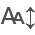

In [100]:
import numpy as np
import pandas as pd


from libraries import general as ge

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)


import os
os.chdir('/Users/babak.jfard/projects/EPHTracking')

### Preparing the tables

In [99]:
bd_grouped = pd.read_csv('Data/BIRTHDEFECTS080823/BirthDefects_without_TBL_BPA.csv')
lb_grouped = pd.read_csv('Data/BIRTHDEFECTS080823/live_births_summarized.csv')

In [102]:
# Check if all the years have all 93 counties
lb_grouped.groupby('StartDate')['County'].nunique()

StartDate
20050101    93
20060101    93
20070101    93
20080101    93
20090101    93
20100101    93
20110101    93
20120101    92
20130101    93
20140101    93
20150101    93
20160101    93
20170101    93
20180101    93
20190101    93
20200101    93
20210101    93
Name: County, dtype: int64

In [103]:
# Which county is missing in 20120101?
set(lb_grouped.County) - set(lb_grouped[lb_grouped['StartDate']==20120101]['County'])

{31117}

In [104]:
import pandas as pd

def check_and_insert_row(df, new_row, key_columns):
    """
    Check if a new row is a duplicate based on key columns and insert it if not.

    Parameters:
    df (pd.DataFrame): The DataFrame to check against.
    new_row (dict): The new row to insert, in the form of a dictionary.
    key_columns (list): The list of columns to check for duplicates.

    Returns:
    tuple: (is_duplicate, df)
        is_duplicate (bool): True if the new row is a duplicate, False otherwise.
        df (pd.DataFrame): The updated DataFrame with the new row inserted if not a duplicate.
    """
    # Check if the new_row values for key columns match any existing rows
    is_duplicate = (df[key_columns] == pd.Series(new_row, index=key_columns)).all(axis=1).any()

    if is_duplicate:
        print("The new row is a duplicate based on the key columns.")
    else:
        print("The new row is not a duplicate and has been added to the DataFrame.")
        # Add the new row to the DataFrame
        #df = df.append(new_row, ignore_index=True)
        new_row_df = pd.DataFrame([new_row])
        df = pd.concat([df, new_row_df], ignore_index=True)
    
    return is_duplicate, df

# Example usage:
# df is your existing DataFrame
# new_row is a dictionary with your new row data
# key_columns are the columns you want to check for duplicates
# is_duplicate, updated_df = check_and_insert_row(df, new_row, key_columns)


In [105]:
# Adding a new row for 2012
new_row = {'County': 31117 , 'StartDate': 20120101, 'MaternalAgeGroup':9, 'MaternalEthnicity': "U",
       'MaternalRace': "U", 'InfantSex': "U", 'TLB': 0}
key_columns = ['County', 'StartDate', 'MaternalAgeGroup', 'MaternalEthnicity',
       'MaternalRace', 'InfantSex']
_, lb_grouped = check_and_insert_row(lb_grouped, new_row, key_columns)


The new row is not a duplicate and has been added to the DataFrame.


In [106]:
# Checking again
lb_grouped.groupby('StartDate')['County'].nunique()

StartDate
20050101    93
20060101    93
20070101    93
20080101    93
20090101    93
20100101    93
20110101    93
20120101    93
20130101    93
20140101    93
20150101    93
20160101    93
20170101    93
20180101    93
20190101    93
20200101    93
20210101    93
Name: County, dtype: int64

In [111]:
bd_grouped

Unnamed: 0  BirthDefect  County  StartDate   EndDate  MaternalAgeGroup  \
0              0         21.0   31001   20060101  20061231                 3   
1              1         21.0   31001   20160101  20161231                 3   
2              2         21.0   31001   20180101  20181231                 2   
3              3         21.0   31003   20080101  20081231                 4   
4              4         21.0   31013   20060101  20061231                 5   
...          ...          ...     ...        ...       ...               ...   
3775        3775         32.0   31179   20190101  20191231                 6   
3776        3776         32.0   31181   20110101  20111231                 5   
3777        3777         32.0   31185   20070101  20071231                 6   
3778        3778         32.0   31185   20170101  20171231                 5   
3779        3779         32.0   31185   20180101  20181231                 3   

     MaternalEthnicity MaternalRace InfantSex  LBWBD  LBFDTWD  
0                   NH            B         F      1        1  
1                    H            O         M      0        1  
2                   NH            W         F      1        1  
3                   NH            W         M      1        1  
4                   NH            W         F      0        1  
...                ...          ...       ...    ...      ...  
3775                NH            W         M      1        1  
3776                NH            W         F      1        1  
3777                NH            W         F      1        1  
3778                NH            W         F      1        1  
3779                NH            W         M      1        1  

[3780 rows x 11 columns]

In [109]:
# The key columns to join the live birth and birth defects tables
key_cols = ['County', 'StartDate', 'MaternalAgeGroup', 'MaternalEthnicity', 'MaternalRace', 'InfantSex']

In [91]:
# Comparing the unique values of key columns in each df befor joining them
def comp_col_types(lb_grouped, bd_grouped, key_cols):
    lb_cols = lb_grouped[key_cols].dtypes.to_list()
    bd_cols = bd_grouped[key_cols].dtypes.to_list()

    if lb_cols == bd_cols:
        print("Columns match. We're good to go!")
    else:
        print("There are some mismatches between key columns")
        print(key_cols)
        print(f"Birth Defects: {bd_cols}")
        print(f"Live Births: {lb_cols}")


In [92]:
comp_col_types(lb_grouped, bd_grouped, key_cols)

Columns match. We're good to go!


In [93]:
# Checking for the differences in the unique values for corresponding columns
for col in key_cols:
    values_bd = set(bd_grouped[col])
    values_lb = set(lb_grouped[col])
    
    unique_to_bd = values_bd - values_lb
    unique_to_lb = values_lb - values_bd
    
    print(f"Values in {col} unique to Birth Defects: {unique_to_bd}")
    print(f"Values in {col} unique to Live Births: {unique_to_lb}\n")



Values in County unique to Birth Defects: set()
Values in County unique to Live Births: {31009, 31171, 31117, 31091, 31165, 31007}

Values in StartDate unique to Birth Defects: set()
Values in StartDate unique to Live Births: set()

Values in MaternalAgeGroup unique to Birth Defects: set()
Values in MaternalAgeGroup unique to Live Births: set()

Values in MaternalEthnicity unique to Birth Defects: set()
Values in MaternalEthnicity unique to Live Births: set()

Values in MaternalRace unique to Birth Defects: set()
Values in MaternalRace unique to Live Births: set()

Values in InfantSex unique to Birth Defects: set()
Values in InfantSex unique to Live Births: {'U'}



### Outer join between Birth Defects and Live Births
We will have all counties present in each year. But LBWBD and LBFDTWD values for many cases will be 0 because there is no Birth Defect in such cases. It will require an outer join method. Also, each birth defct when added for TLBs must add up into total live births. Therefore, we separate BD data for each BirthDefect, do outer join and in the end concatenate all the resulted 12 tables into one final table

***Note:*** to make sure that the denominator for each Birth Defect is the total live birth, data for each birth defect is separated and is outer joined with the live birth data, and in the end all the separate 12 joined tables are concatenated into the final dataframe. 

In [67]:
# Merging the two datasets
all_bds = []  # Create an empty list to store the dataframes

# Loop over unique values of 'BirthDefects' column in bd_grouped
for defect in bd_grouped['BirthDefect'].unique():
    # Separate rows with the current 'BirthDefects' value
    current_defect_df = bd_grouped[bd_grouped['BirthDefect'] == defect]
    
    # Perform the outer join with lb_grouped on key columns
    merged_df = lb_grouped.merge(current_defect_df, on=key_cols, how='outer')
    
    # For unassigned 'BirthDefects', change them to the current 'BirthDefect' value
    merged_df['BirthDefect'].fillna(defect, inplace=True)
    
    # Add the new dataframe to the 'all_bds' list
    all_bds.append(merged_df)

# Continue the loop for the next 'BirthDefect'


In [68]:
final_bd = pd.concat(all_bds, ignore_index=True)

* Next step will be to take care of Nan values for non-matched rows

In [72]:
final_bd.drop(columns='Unnamed: 0', inplace=True)

In [73]:
final_bd.isna().sum()

County                    0
StartDate                 0
MaternalAgeGroup          0
MaternalEthnicity         0
MaternalRace              0
InfantSex                 0
TLB                     260
BirthDefect               0
EndDate              368528
LBWBD                368528
LBFDTWD              368528
dtype: int64

1) TLB: TLB is for those cases that we have maternal age 9. This is exactly the same number as we had in the first approach. Therefore we set them to -999
2) BirthDefect: For cases that we only want to provide live births. We add 21
3) EndDate = (StartDate // 1e4)* 1e4 + 1231
4) LBWBD will be 0 for all missing values
5) LBFDTWD same as LBWBD

In [135]:
final_bd['TLB'].fillna(-999, inplace=True)
final_bd['EndDate'] = (final_bd['StartDate'] // 1e4) * 1e4 + 1231
final_bd['LBWBD'].fillna(0, inplace=True)
final_bd['LBFDTWD'].fillna(0, inplace=True)

In [136]:
data_toSave = final_bd

### Final step: Prepare Data to Save
This is the final step to save data into format and numbers that can be submitted to the Tracking system

In [137]:
# Order the columns in the same order as Data Dictionary
ordered_columns = ['County', 'StartDate', 'EndDate', 'BirthDefect', 'MaternalAgeGroup',
                   'MaternalEthnicity', 'MaternalRace', 'InfantSex', 'TLB', 'LBWBD', 'LBFDTWD']

data_toSave = data_toSave[ordered_columns]

In [138]:
# Checking the data types
data_toSave.dtypes

County                 int64
StartDate              int64
EndDate              float64
BirthDefect            int64
MaternalAgeGroup       int64
MaternalEthnicity     object
MaternalRace          object
InfantSex             object
TLB                  float64
LBWBD                float64
LBFDTWD              float64
dtype: object

In [139]:
cols_to_int = ['EndDate', 'BirthDefect', 'TLB', 'LBWBD', 'LBFDTWD']
data_toSave[cols_to_int] = data_toSave[cols_to_int].astype('int')

data_toSave.InfantSex.replace({'N': 'U'}, inplace=True)

In [140]:
# final check
for i in range(8):
    col = data_toSave.columns[i]
    print(f'Column: {col}')
    print(data_toSave[col].unique())
    print('\n')

Column: County
[31001 31003 31005 31007 31009 31011 31013 31015 31017 31019 31021 31023
 31025 31027 31029 31031 31033 31035 31037 31039 31041 31043 31045 31047
 31049 31051 31053 31055 31057 31059 31061 31063 31065 31067 31069 31071
 31073 31075 31077 31079 31081 31083 31085 31087 31089 31091 31093 31095
 31097 31099 31101 31103 31105 31107 31109 31111 31113 31115 31117 31119
 31121 31123 31125 31127 31129 31131 31133 31135 31137 31139 31141 31143
 31145 31147 31149 31151 31153 31155 31157 31159 31161 31163 31165 31167
 31169 31171 31173 31175 31177 31179 31181 31183 31185]


Column: StartDate
[20050101 20060101 20070101 20080101 20090101 20100101 20110101 20120101
 20130101 20140101 20150101 20160101 20170101 20180101 20190101 20200101
 20210101]


Column: EndDate
[20051231 20061231 20071231 20081231 20091231 20101231 20111231 20121231
 20131231 20141231 20151231 20161231 20171231 20181231 20191231 20201231
 20211231]


Column: BirthDefect
[21 22 23 24 25 26 27 28 29 30 31 32]


Colu

In [96]:
# Now saving each year into a separate file:
#output_folder = 'Data/BIRTHDEFECTS080823/To_Submit/'
output_folder = 'Data/BIRTHDEFECTS080823/final_submit/'

for st_date in data_toSave.StartDate.unique():
    to_save = data_toSave[data_toSave['StartDate'] == st_date]
    to_save.index = range(1, len(to_save) + 1)
    year = (st_date//1e4).astype('int').astype('str')
    filename = output_folder+'BirthDefects_AllCounties_'+year+ '.csv'

    to_save.to_csv(filename, index = True,index_label='RowIdentifier')

## A. Some Checks
Some checks to make sure the data makes sense
 

* Checking if the sum of TLBs for each BirthDefect adds up to total live births in each year

In [141]:
def sum_ignore_values(series, ignore=-999):
    return series.replace(ignore, np.nan).sum()

data_toSave.pivot_table(index='StartDate', columns='BirthDefect', values='TLB', aggfunc=lambda x: sum_ignore_values(x))

BirthDefect     21     22     23     24     25     26     27     28     29  \
StartDate                                                                    
20050101     25103  25103  25103  25103  25103  25103  25103  25103  25103   
20060101     25661  25661  25661  25661  25661  25661  25661  25661  25661   
20070101     25822  25822  25822  25822  25822  25822  25822  25822  25822   
20080101     25885  25885  25885  25885  25885  25885  25885  25885  25885   
20090101     25899  25899  25899  25899  25899  25899  25899  25899  25899   
20100101     24937  24937  24937  24937  24937  24937  24937  24937  24937   
20110101     24834  24834  24834  24834  24834  24834  24834  24834  24834   
20120101     25010  25010  25010  25010  25010  25010  25010  25010  25010   
20130101     25159  25159  25159  25159  25159  25159  25159  25159  25159   
20140101     25819  25819  25819  25819  25819  25819  25819  25819  25819   
20150101     25728  25728  25728  25728  25728  25728  25728  25728  25728   
20160101     25656  25656  25656  25656  25656  25656  25656  25656  25656   
20170101     24885  24885  24885  24885  24885  24885  24885  24885  24885   
20180101     24538  24538  24538  24538  24538  24538  24538  24538  24538   
20190101     23860  23860  23860  23860  23860  23860  23860  23860  23860   
20200101     23419  23419  23419  23419  23419  23419  23419  23419  23419   
20210101     23646  23646  23646  23646  23646  23646  23646  23646  23646   

BirthDefect     30     31     32  
StartDate                         
20050101     25103  25103  25103  
20060101     25661  25661  25661  
20070101     25822  25822  25822  
20080101     25885  25885  25885  
20090101     25899  25899  25899  
20100101     24937  24937  24937  
20110101     24834  24834  24834  
20120101     25010  25010  25010  
20130101     25159  25159  25159  
20140101     25819  25819  25819  
20150101     25728  25728  25728  
20160101     25656  25656  25656  
20170101     24885  24885  24885  
20180101     24538  24538  24538  
20190101     23860  23860  23860  
20200101     23419  23419  23419  
20210101     23646  23646  23646

* Plotting the Sum, max, mean, min for each Birth Defect in each year

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_summaries(df, groups, coexist, x_column, nrow):
    # Get unique values from the groups column
    unique_groups = df[groups].unique()
    
    # Calculate number of columns for the grid
    ncol = len(unique_groups) // nrow
    if len(unique_groups) % nrow != 0:
        ncol += 1
    
    # Initialize a figure
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 10))
    
    # If there's only one row or one column, axes is a 1D array
    if nrow == 1 or ncol == 1:
        axes = axes.reshape(nrow, ncol)
    
    # Iterate over each unique group and plot
    for idx, group in enumerate(unique_groups):
        ax = axes[idx // ncol, idx % ncol]
        
        # Filter dataframe for the current group
        subset = df[df[groups] == group]
        
        # Plot each column in coexist
        for col in coexist:
            sns.lineplot(data=subset, x=x_column, y=col, ax=ax, label=col)
        
        ax.set_title(f"{groups}: {group}")
        ax.legend()
    
    # If there are empty subplots, hide them
    for idx in range(len(unique_groups), nrow * ncol):
        axes[idx // ncol, idx % ncol].axis('off')
    
    plt.tight_layout()
    plt.show()


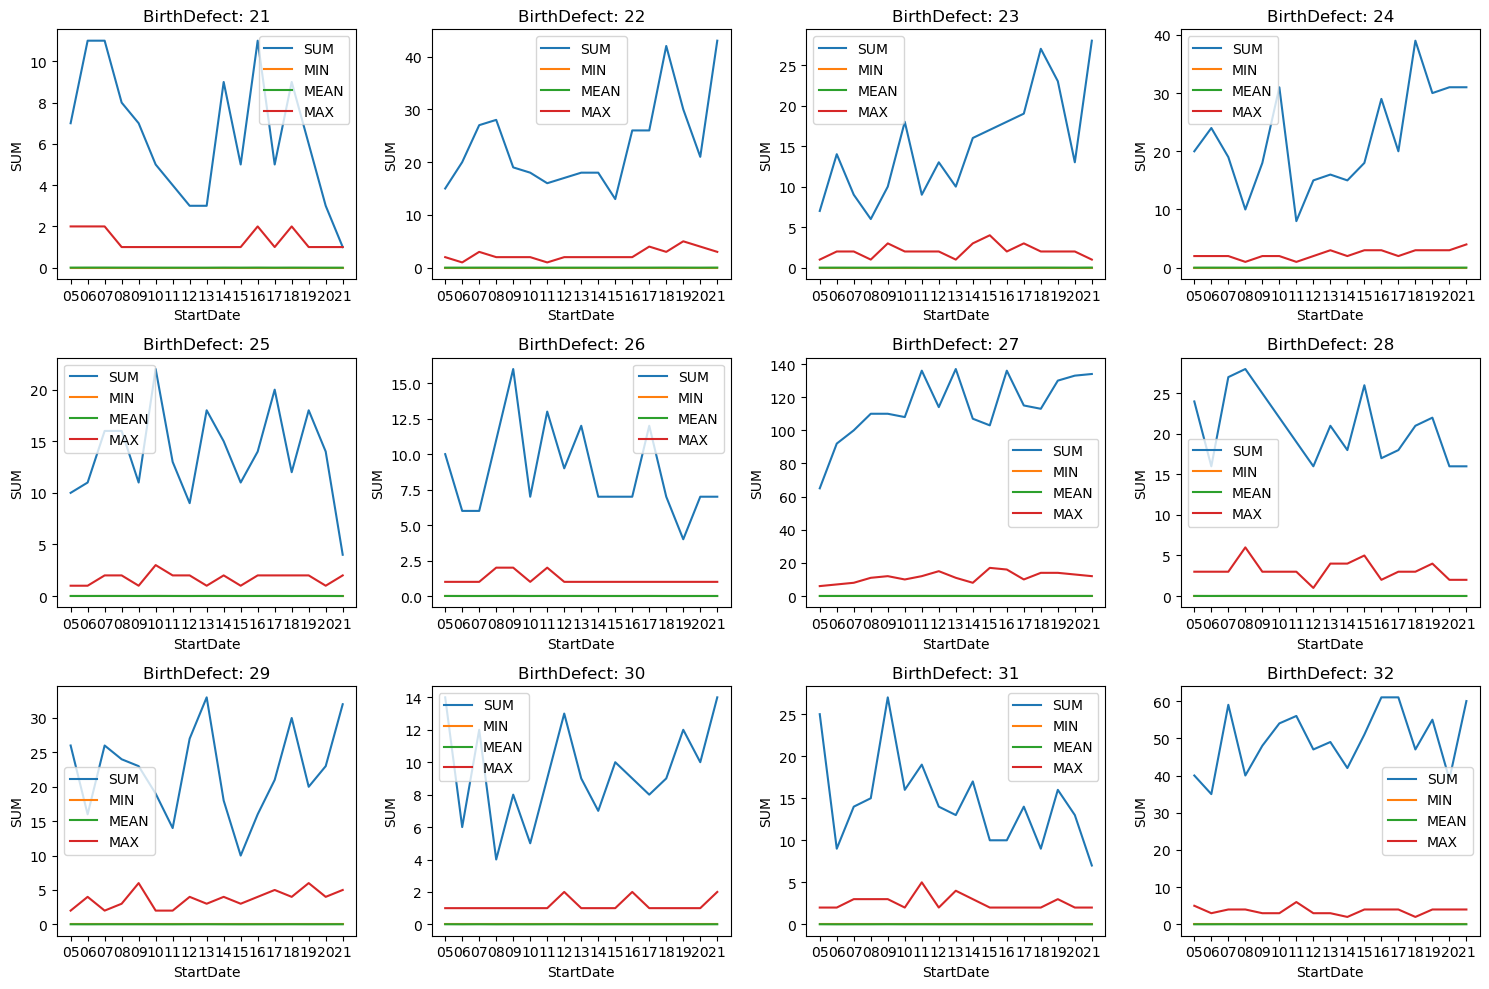

In [104]:
ds_summary = data_toSave.groupby(['BirthDefect', 'StartDate'])['LBFDTWD'].agg(SUM = 'sum', MIN='min', MEAN='mean', MAX='max').reset_index()
ds_summary['BirthDefect'] = ds_summary['BirthDefect'].astype('int')
ds_summary.StartDate = ds_summary.StartDate.astype('str').str[2:4]

plot_summaries(df=ds_summary, groups='BirthDefect', coexist=['SUM', 'MIN', 'MEAN', 'MAX'], x_column='StartDate', nrow=3)